In [61]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [62]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [63]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

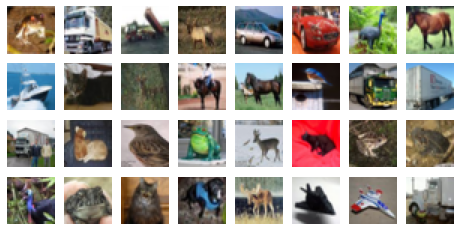

In [64]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [65]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

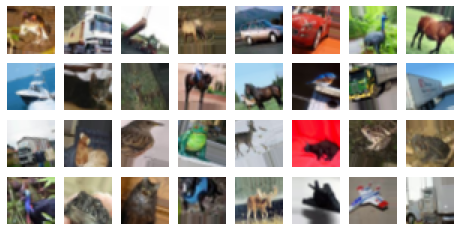

In [66]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [67]:
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
import os

In [68]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [69]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

# 讀取資料並檢視
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# 對 label 進行 one-hot encoding (y_trian 原本是純數字)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [70]:
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 64)       

In [71]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [75]:
model.fit_generator(data_generator.flow(x_train, y_train, batch_size=32), 
                    steps_per_epoch=len(x_train)/batch_size, 
                    epochs=epochs,
                    shuffle=True,
                    validation_data=(x_test, y_test))

Epoch 1/10
391/390 [==============================] - 4s 11ms/step - loss: 1.4009 - accuracy: 0.5070 - val_loss: 1.1645 - val_accuracy: 0.5885
Epoch 2/10
391/390 [==============================] - 4s 11ms/step - loss: 1.3744 - accuracy: 0.5141 - val_loss: 1.2065 - val_accuracy: 0.5860
Epoch 3/10
391/390 [==============================] - 4s 11ms/step - loss: 1.3745 - accuracy: 0.5154 - val_loss: 1.2920 - val_accuracy: 0.5535
Epoch 4/10
391/390 [==============================] - 4s 11ms/step - loss: 1.3628 - accuracy: 0.5233 - val_loss: 1.2412 - val_accuracy: 0.5513
Epoch 5/10
391/390 [==============================] - 4s 11ms/step - loss: 1.3510 - accuracy: 0.5248 - val_loss: 1.1076 - val_accuracy: 0.6165
Epoch 6/10
391/390 [==============================] - 4s 11ms/step - loss: 1.3615 - accuracy: 0.5257 - val_loss: 1.4053 - val_accuracy: 0.5265
Epoch 7/10
391/390 [==============================] - 4s 11ms/step - loss: 1.3573 - accuracy: 0.5342 - val_loss: 1.3351 - val_accuracy: 0.5507

In [76]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.3659322261810303
Test accuracy: 0.5608000159263611
